<center>
    <h1>Target Trial Emulation</h1>
    By Christian Abay-abay & Thristan Jay Nakila
</center>

## **Instructions**

1. Extract the dummy data from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) and save it as `data_censored.csv`.
2. Convert the R code to Python in a Jupyter Notebook, ensuring the results match the original.
3. Create a second version (`TTE-v2.ipynb`) with additional analysis.
4. Integrate clustering in `TTE-v2`, determine where it fits, and generate insights.
5. Work in pairs, preferably with your thesis partner.
6. Push your Jupyter Notebooks (`TTE.ipynb` and `TTE-v2.ipynb`) to GitHub.
7. 📅 **Deadline:** February 28, 2025, at **11:59 PM**.


***
<center>
    <h2>Converting R Code to Python</h2>
    R Code from [RPubs - TTE](https://rpubs.com/alanyang0924/TTE) converted to Python code for this notebook.
</center>

### 1. Setting Up - Define Estimand and Create Directories

In [1]:
trial_itt = {
    "estimand": "ITT",
    "directory": "temp/trial_itt"
}

### 2. Load Data
This loads data_censored.csv and inspects the first few rows.

In [2]:
import pandas as pd

file_path = 'data/data_censored.csv'
data_censored = pd.read_csv(file_path)

trial_itt = {
    "estimand": "ITT",
    "directory": "temp/trial_itt",
    "data": data_censored
}

print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


### 3. Fit Censoring Weight Models
Fit two logistic regression models — numerator and denominator for inverse probability of censoring weights (IPCW).

In [3]:
import statsmodels.api as sm

data_censored['not_censored'] = 1 - data_censored['censored']

numerator_model = sm.Logit(
    data_censored['not_censored'],
    sm.add_constant(data_censored[['x2']])
).fit(disp=0)

denominator_model = sm.Logit(
    data_censored['not_censored'],
    sm.add_constant(data_censored[['x2', 'x1']])
).fit(disp=0)

data_censored['p_numerator'] = numerator_model.predict(sm.add_constant(data_censored[['x2']]))
data_censored['p_denominator'] = denominator_model.predict(sm.add_constant(data_censored[['x2', 'x1']]))

data_censored['weight'] = data_censored['p_numerator'] / data_censored['p_denominator']

trial_itt['data'] = data_censored

### 4. Expand Data - Baseline Setup
Only keep period 1 data (entry point into the trial).

In [4]:
expanded_data = data_censored[data_censored['period'] == 1].copy()

### 5. Generate Follow-Up Time and Assigned Treatment
Expand each row to 11 rows (follow-up 0 to 10), and create required columns.

In [5]:
import numpy as np
import statsmodels.api as sm

# 5. Expand data for follow-up times (0 to 10)
expanded_data = data_censored[data_censored['period'] == 1].copy()

# Expand each row into 11 rows (follow-up time 0 to 10)
expanded_data = expanded_data.loc[expanded_data.index.repeat(11)].reset_index(drop=True)
expanded_data['followup_time'] = np.tile(np.arange(11), len(expanded_data) // 11)

# Assign initial treatment to all rows
expanded_data['assigned_treatment'] = expanded_data['treatment']

# Precompute follow-up time squared
expanded_data['followup_time_squared'] = expanded_data['followup_time'] ** 2

# Drop outcome if already present (for clean merge)
if 'outcome' in expanded_data.columns:
    expanded_data = expanded_data.drop(columns=['outcome'])

# Merge back outcomes and weights in one go (corrected to avoid suffix clash)
expanded_data = expanded_data.merge(
    data_censored[['id', 'period', 'outcome', 'weight']],
    left_on=['id', 'followup_time'],
    right_on=['id', 'period'],
    how='left',
    suffixes=('', '_censored')
)

# Drop the redundant 'period' column (keeping only followup_time)
expanded_data = expanded_data.drop(columns=['period'], errors='ignore')

# Important Fix: If outcome is missing (future timepoints not recorded), set it to 0
expanded_data['outcome'] = expanded_data['outcome'].fillna(0)

# Double-check
print("Step 5-6 Outcome Distribution:")
print(expanded_data['outcome'].value_counts(dropna=False))

# 6. Fit Outcome Model (Logit with IPC Weights)
X = sm.add_constant(expanded_data[['assigned_treatment', 'x2', 'followup_time', 'followup_time_squared']])
y = expanded_data['outcome']

# Fix any missing or zero weights to a very small non-zero value
expanded_data['weight'] = expanded_data['weight'].fillna(1e-6).replace(0, 1e-6)

# Fit weighted logistic regression (this is the core outcome model)
outcome_model = sm.GLM(
    y, X, family=sm.families.Binomial(), freq_weights=expanded_data['weight']
).fit()

# Store model and column list for later prediction (step 7)
trial_itt = {}
trial_itt['outcome_model'] = outcome_model
trial_itt['outcome_columns'] = X.columns.tolist()

print(outcome_model.summary())

Step 5-6 Outcome Distribution:
outcome
0.0    675
1.0      7
Name: count, dtype: int64
                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                  682
Model:                            GLM   Df Residuals:                   677.55
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -35.667
Date:                Wed, 05 Mar 2025   Deviance:                       71.333
Time:                        02:26:38   Pearson chi2:                 1.63e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.01082
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

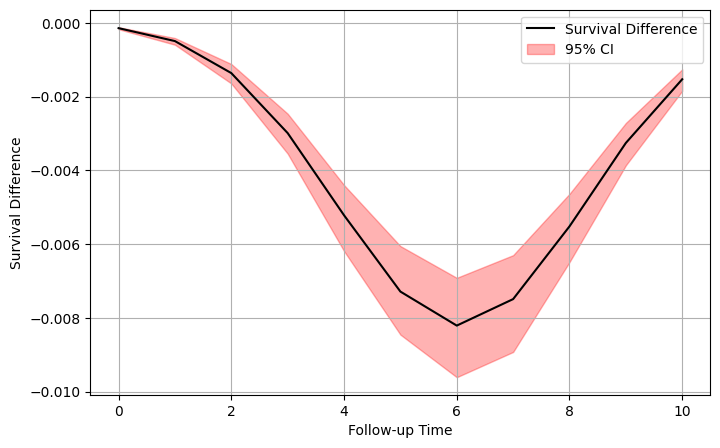

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 7. Predict Survival for Both Treatment Arms (with Recomputed Columns)
def predict_survival(data, assigned_treatment):
    temp = data.copy()
    temp['assigned_treatment'] = assigned_treatment
    if 'followup_time_squared' not in temp.columns:
        temp['followup_time_squared'] = temp['followup_time'] ** 2

    temp = sm.add_constant(temp)

    # Align to the columns used during training (critical)
    X = temp[trial_itt['outcome_columns']]
    logit_risk = trial_itt['outcome_model'].predict(X)
    survival_prob = 1 - logit_risk

    return survival_prob.groupby(temp['followup_time']).mean()

# Add constant (intercept) column if missing
if 'const' not in expanded_data.columns:
    expanded_data = sm.add_constant(expanded_data)

# Predict survival for both treatment arms
survival_treatment = predict_survival(expanded_data, assigned_treatment=1)
survival_control = predict_survival(expanded_data, assigned_treatment=0)

# 8. Calculate Survival Difference (per follow-up time)
survival_diff = survival_treatment - survival_control

# 8.1 Bootstrap to compute correct pointwise confidence intervals
n_bootstraps = 1000
boot_diffs = np.zeros((n_bootstraps, len(survival_diff)))

for b in range(n_bootstraps):
    # Resample subjects with replacement
    boot_sample = expanded_data.groupby('id').sample(frac=1, replace=True)

    # Predict survival curves for bootstrap sample
    surv_treat_boot = predict_survival(boot_sample, assigned_treatment=1)
    surv_control_boot = predict_survival(boot_sample, assigned_treatment=0)

    # Compute survival difference for bootstrap sample
    boot_diffs[b, :] = surv_treat_boot.values - surv_control_boot.values

# Compute 95% bootstrap confidence intervals (percentile method)
ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
ci_upper = np.percentile(boot_diffs, 97.5, axis=0)

# 9. Plot Survival Difference with 95% Confidence Interval
plt.figure(figsize=(8, 5))

plt.plot(survival_diff.index, survival_diff, color='black', label='Survival Difference')
plt.fill_between(survival_diff.index, ci_lower, ci_upper, color='red', alpha=0.3, label='95% CI')

plt.xlabel("Follow-up Time")
plt.ylabel("Survival Difference")
plt.legend()
plt.grid(True)
plt.show()